#### Christopher B. Johnson
#### 11/12/17


# Project: Investigate What Makes a Movie Exceptional

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

>This project will explore the different variables involved in making movies that are exceptional.  So, what defines a good movie?  

>  Using the dataset from the tmdb database, and for the sake of this investigation, a good movie can be defined in three ways : popularity, film profit as proportion of budget (here I'm going to adjust this result by budget, so that a film with a 1 mil budget that makes 1 mil in profits is considered more successful than a 100 mil budget film that makes 1 mil)  $$filmProfit = \frac{revenue-budget}{budget}$$, or the average voter score.  These three dependent variables address the more generic variables of fame, fortune, and quality, respectively.  Finally, there is Chris' opinion on the matter, which after a brief review of the data, suggests that this is a highly subjective topic.

>  Given the size of the dataset (approximately 10,000 movies), each definition of successful will be set to the top 500 movies (5%), since this appears to capture most of the significant information.

## Questions

>>1. Is there some common combination of genres that most successful movies share?
>>2. Is there any correlation between the budget of successful movies and their perceived quality?
>>3. Are higher quality movies more popular?

>In order to answer these questions, as stated above, first movies will be ranked by 3 definitions of success (fame, fortune, and quality).  These will be the dependent variables based on the fields of popularity, (budget,revenue), and voter_average.  Then an attempt will be made to find any interesting correlations from these questions.

### Data Uncertainty
> The current website for this data is at https://www.kaggle.com/tmdb/tmdb-movie-metadata

> While it confirms that the existing zeros in the data are to be ignored, it does not answer how the budget_adj and revenue_adj columns are to be considered.  Since these numbers went down in some cases, I don't think that it's adjusting for 2017 dollars, but instead it may be the actual values after review?  Revenues also dropped after adjustment in some cases, and it's just not clear what these adjusted numbers represent, so they will not be used.

In [2]:
#import all packages for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#make all plots in the notebook vs separate window
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

> In this section, the movie csv file is loaded into a dataframe and the tail is displayed to show some concerns with the data.  The problems are as follows :
1.  There are zeroes in the budget, revenue, budget_adj and revenue_adj columns.  These are likely not real values, and are simply placeholders.  These movies should not be included in the assessment of success using net profits, as they would wildly skew the results, and there is no immediate way to easily resolve the lack of information.
2.  There are some useless columns that are cluttering up the table for this analysis, such as homepage, tagline, and overview, and will not be used.  While it could be interesting to look at the vocabulary and punctuation to see if say, more !'s result in more viewers, this will not be pursued.
3.  While creating the money rank, the highest performers had a rank of over 1 million.  Upon further inspection, for those movies, someone had entered the budget assuming millions and then put down absolute revenue.  For example, id 10495, Karate Kid III has a budget of 113.00 and a revenue of 115103979.  While it's rather crude, I'm going to assume that all movies have a budget of greater than 100,000.  I'm going to leave the revenue alone for now.
4.  While working on casting the genres from lists to sets, it failed on index 426, which is a blank cell.  It was identifying this cell as float instead of empty list.  This was a lesson in groupby not taking mutable types, so I cast the column to string, then split on |, converted to set (to remove duplicates), and then sorted the set and cast to tuple (a non-mutable iterator which can be used by groupby).  This fixed the genre column, and while I also applied it to director (likely unnecessary) and actors (flawed due to it not finding individuals so much as a certain group...that works for genre, but not so much for actors).

### General Properties

In [10]:
# Loading the movie data and doing an initial inspection.  Other problems were found as documented above.

filename = 'tmdb-movies.csv'
df_movies = pd.read_csv(filename)
print df_movies.tail()

          id    imdb_id  popularity  budget  revenue  \
10861     21  tt0060371    0.080598       0        0   
10862  20379  tt0060472    0.065543       0        0   
10863  39768  tt0060161    0.065141       0        0   
10864  21449  tt0061177    0.064317       0        0   
10865  22293  tt0060666    0.035919   19000        0   

                 original_title  \
10861        The Endless Summer   
10862                Grand Prix   
10863       Beregis Avtomobilya   
10864    What's Up, Tiger Lily?   
10865  Manos: The Hands of Fate   

                                                    cast homepage  \
10861  Michael Hynson|Robert August|Lord 'Tally Ho' B...      NaN   
10862  James Garner|Eva Marie Saint|Yves Montand|Tosh...      NaN   
10863  Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...      NaN   
10864  Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...      NaN   
10865  Harold P. Warren|Tom Neyman|John Reynolds|Dian...      NaN   

                 director            

### Prepare the data for investigation

>The approach here will be to create multiple tables much like preparing a schema for a database.  Once the tables are built, we can sort them as desired, and then do the necessary joins to create the associations in preparation for display.

>First prepare the table of independent variables.  The common fields dataframe had problems; specifically, around index 426, there was an empty cell in the data which was considered a float, when all other values were objects.  This caused a crash.  The intent with the genres was to look at what combinations of genres would be associated with successful movies, so it was desireable to capture the combinations.  However, this resulted in combinations such as drama,comedy and comedy,drama as separate entries.  The answer is to simply compare sets, but that became difficult since groupby will not work on mutable data objects.  So, while tuples would work, they didn't actually solve the problem of order significance.  Hence the solution below of first casting to string (eliminate the float) so I can split to a list on a | token.  Then take the list and convert to a set to eliminate any possible duplicates in the data set.  Finally return the sorted tuple, to fix the order significance problem when feeding into groupby.

In [13]:
independentFields = ['id','budget','cast','director','genres']
df_commonFields = pd.read_csv(filename,usecols=independentFields)

#define function to take in dataframe of independent fields and groom it to support groupby functions
listOfColumns = ['genres','cast','director']
#need to convert from set to tuple b/c groupby can't work on mutable objects
#https://stackoverflow.com/questions/39622884/pandas-groupby-over-list
def groomIndependentVars(df, colList):
    def setToTuple(x):
        return tuple(sorted(x))
    for column in colList:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.split(pat='|')
        df[column] = df[column].apply(set)
        df[column] = df[column].apply(setToTuple)
    return df

df_commonFields = groomIndependentVars(df_commonFields,listOfColumns)

### Movies ranked by Money

Find the top 500 movies as defined by monetary success.  There were some problems when merging the money dataframe with the commonField dataframe above, as both had the budget column.  A fix for this was to create a suffix on the current table and then drop that column after the merge.

In [15]:
################by money :
moneyFields = ['id','budget','revenue']
df_movieMoney = pd.read_csv(filename, usecols=moneyFields)
#prep money fields to float for division
#https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas
df_movieMoney[['budget','revenue']] = df_movieMoney[['budget','revenue']].astype(float)

def rankByMoney(df):
    if (df['revenue'] > 1) and (df['budget'] > 100000):
        return (df['revenue'] - df['budget']) / df['budget']
    else:
        return -100

#using sort_values due to this timing experiment :
#https://stackoverflow.com/questions/41825978/sorting-columns-and-selecting-top-n-rows-in-each-group-pandas-dataframe
df_movieMoney['moneyRank'] = df_movieMoney.apply(rankByMoney, axis=1).sort_values(ascending = False)

#now get top 500 moneyRanked movies and look for common directors
df_topMovieMoney = df_movieMoney.sort_values(by=['moneyRank'],ascending=False).head(500)

dfMergedMoney = df_topMovieMoney.merge(df_commonFields, on='id', how='inner', suffixes=('', '_'))
#now fix merge
#https://stackoverflow.com/questions/40343061/duplicate-columns-with-pandas-merge
dfMergedMoney.drop('budget_', axis=1, inplace=True)

#look at most popular genres for top money makers
topMoneyGenres = dfMergedMoney.groupby(dfMergedMoney['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top money makers
#print dfMergedMoney.groupby(dfMergedMoney['director']).size().sort_values(ascending=False).head()
#now look at actors in top money making movies
#print dfMergedMoney.groupby(dfMergedMoney['cast']).size().sort_values(ascending=False).head()

While I did not do this initially, a histogram of the money statistic would have proved helpful to determine how to examine the data.  After working with all of the data for a while, it became evident that there were many situations where the data was highly skewed to a particular value (for instance, there are a number of movies with only a few reviewers).  So, to start the data preparation, let's look at how the data is distributed to estimate how many data samples of the population would be meaningful.

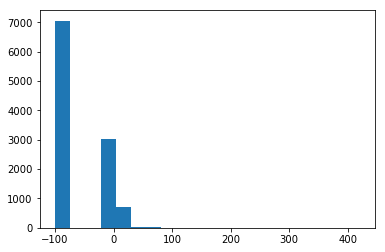

In [26]:
plt.hist(df_movieMoney['moneyRank'],bins = 20);

As can be seen in the histogram above, it seems to have been a good decision to select only the top 500 movies for analysis, as many more actually lost money, and almost 7000 of the 10000 movies available either had incomplete data, or budgets under 100,000 dollars. The budget limit may have been in error, but let's look at the budget histogram.

40
         id   budget    revenue  moneyRank
1354    985  10000.0  7000000.0     -100.0
1733  22717     75.0      134.0     -100.0
1871  42151  31192.0    10000.0     -100.0
2207  42296  30000.0  3045943.0     -100.0
2227  38568  30000.0   617000.0     -100.0


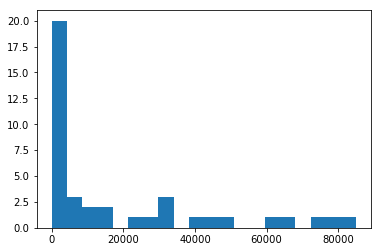

In [50]:
df_movieMoney100Hist = df_movieMoney[(df_movieMoney['budget']<100000) & (df_movieMoney['budget']>1) & \
                                    (df_movieMoney['revenue'] > 0)]
print len(df_movieMoney100Hist)
print df_movieMoney100Hist.head()
plt.hist(df_movieMoney100Hist['budget'], bins=20);

As the idea of using histograms to better select my data arrived after I put most of this together, I'm going to leave this mistake in this report.  The histogram above shows that I left out 40 movies that had legitimate budget/revenue streams, but I did not think to include them originally due to a more 'by brief inspection of the spreadsheet' approach.

However, this does mean that the results of the money ranking will be significantly skewed, as these movies could possibly be some of the highest earners, as defined above.  I find my mistake here interesting, which is why I've left it in.

### Movies Ranked by Quality

Now find the top 500 movies ranked by quality.  This required a bit of consideration as to what the balance should be between the actual vote average versus the number of votes.  The fewer votes there were for a movie greatly increased the volatility of its rank.  In looking at the statstical description of the voter fields, the mean was low and the standard deviation quite high, relatively speaking.  So instead, looking at the IQR for the data seemed to indicate that there were a lot of movies with very few votes, so I decided that if I simply eliminated the bottom 50 percent of movies due to insufficient votes (making the score unreliable), I might capture a reasonable indicator of quality.  So, 38 votes was that cutoff at 50%.

Also, I did notice that the top ranked casting for these pictures is 'nan', but I decided to stop the exploration at the initial 3 questions due to the realization that there's always going to be 'one more thing' that can be considered.  Hence, there was no driving reason to clean the cast data.

In [51]:
###############by quality
qualityFields = ['id', 'vote_average', 'vote_count']
df_quality = pd.read_csv(filename, usecols=qualityFields)
#cast to float for possible division
df_quality[['vote_average', 'vote_count']] = df_quality[['vote_average', 'vote_count']].astype(float)

print df_quality[['vote_average', 'vote_count']].describe()

#since the standard deviation is greater than the mean, it is difficult to find meaning for review quality with few reviewers.  This makes sense, as the age of some of these movies would mean that they have less reviews.
#I'm going to ignore the number of reviews for this investigation
#standardize the average vote quality\
#The IQR at 50% is 38 votes, so let's make that the lower limit for ranking...it's not fair, but it should help eliminate artifically high scores due to few votes
#due to warnings...
#http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
df_quality.loc[:, 'voteValStandardized']=((df_quality.loc[:, 'vote_average'] - df_quality.loc[:, 'vote_average'].mean()) / df_quality.loc[:, 'vote_average'].std(ddof=0))

print df_quality.sort_values('voteValStandardized', ascending=False).head()
df_qualityReviewNumbers = df_quality[df_quality['vote_count'] >= 38]
df_qualityReviewNumbers = df_qualityReviewNumbers.sort_values('voteValStandardized', ascending=False).head(500)
print df_qualityReviewNumbers.sort_values('voteValStandardized', ascending=False).head()

#now analyze quality
dfMergedQuality = df_qualityReviewNumbers.merge(df_commonFields, on='id', how='inner')
topQualityGenres = dfMergedQuality.groupby(dfMergedQuality['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top quality
print dfMergedQuality.groupby(dfMergedQuality['director']).size().sort_values(ascending=False).head()
#now look at actors in top quality movies
print dfMergedQuality.groupby(dfMergedQuality['cast']).size().sort_values(ascending=False).head()

       vote_average    vote_count
count  10866.000000  10866.000000
mean       5.974922    217.389748
std        0.935142    575.619058
min        1.500000     10.000000
25%        5.400000     17.000000
50%        6.000000     38.000000
75%        6.600000    145.750000
max        9.200000   9767.000000
          id  vote_count  vote_average  voteValStandardized
3894  125336        14.0           9.2             3.448917
538   224972        11.0           8.9             3.128095
2269   51299        27.0           8.8             3.021155
1200  374430        41.0           8.8             3.021155
6911   24970        23.0           8.7             2.914214
          id  vote_count  vote_average  voteValStandardized
1200  374430        41.0           8.8             3.021155
3690   68450        60.0           8.5             2.700333
609   321640        72.0           8.4             2.593393
2397  241829        42.0           8.4             2.593393
4178     278      5754.0          

Again, let's look at the histogram of quality movies and evaluate whether the split at 38 was reasonable.

5397
5.76540670743


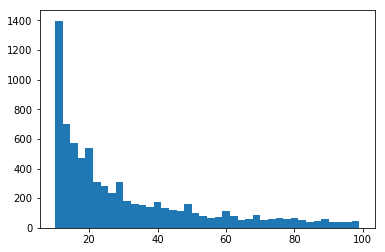

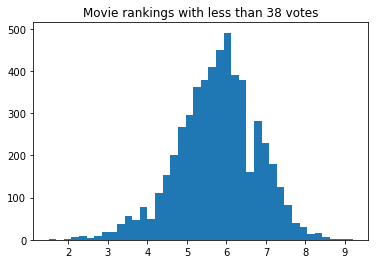

In [67]:
plt.hist(df_quality[df_quality['vote_count']<100]['vote_count'],bins=40);
#how many movies had fewer than 38 votes?
print len(df_quality[df_quality['vote_count']<38])
#make new plot
pltAvg = plt.figure()
#of those with fewer than 38 votes, where did the average movie rank fall?
plt.hist(df_quality[df_quality['vote_count']<38]['vote_average'],bins=40);
plt.title('Movie rankings with less than 38 votes');
print df_quality[df_quality['vote_count']<38]['vote_average'].mean()

From the above (top) histogram and the length of that dataset, it's obvious from the IQR in the description above that half of the movies have fewer than 38 votes (the exact point of the 50% IQR)).  So, given that there are ~5000 movies that had less than 38 votes, let's consider what that would have done to the movie rankings.  Looking at the lower histogram above, it's a rather normal distribution with a mean of 5.76.  While the majority of these rankings may not have influenced the ranking, I believe that the rankings of 8 and greater (maybe 50 movies) would have greatly affected the higher level rankings with very few votes, so it was a reasonable approach to eliminate all of these movies from the quality ranking. 

### Movies Ranked by Popularity

Finally, sort the data by movie popularity.

In [21]:
#################by popularity
popularFields = ['id','popularity']
dfPopularity = pd.read_csv(filename, usecols=popularFields)
#standardize popularity and rank
dfPopularity.loc[:,'popularityStandardized'] = (dfPopularity.loc[:,'popularity'] - dfPopularity.loc[:,'popularity'].mean())/dfPopularity.loc[:,'popularity'].std(ddof=0)
print dfPopularity.sort_values('popularityStandardized',ascending=False).head()
dfPopularityTop = dfPopularity.sort_values('popularityStandardized',ascending=False).head(500)
dfMergedPopularity = dfPopularityTop.merge(df_commonFields, on='id', how='inner')

topPopularGenres = dfMergedPopularity.groupby(dfMergedPopularity['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top quality
topPopularDirectors = dfMergedPopularity.groupby(dfMergedPopularity['director']).size().sort_values(ascending=False).head(10)
#now look at actors in top quality movies
topPopularCast = dfMergedPopularity.groupby(dfMergedPopularity['cast']).size().sort_values(ascending=False).head(10)


         id  popularity  popularityStandardized
0    135397   32.985763               32.334830
1     76341   28.419936               27.769638
629  157336   24.949134               24.299318
630  118340   14.311205               13.662866
2    262500   13.112507               12.464335


Again, let's look at the histogram for popularity.

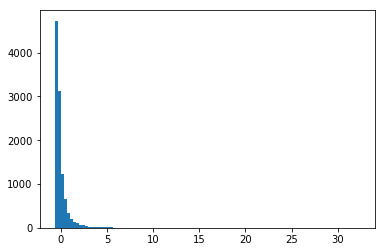

In [71]:
plt.hist(dfPopularity['popularityStandardized'],bins=100);

There are many movies that are not popular.  This would be a more challenging paper if the question were to find the worst movies of all time.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!